In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# add the path to my packages to system paths so they can be imported
import sys
# sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import my_first_feature_extractor as fe
import compare_with_benchmark as bn
import my_simgraph_04 as sg

# Test val-val and val-train edges

In [20]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Load spike data

In [2]:
# load all spike data from file
data_path = '../../../data/original_files/'
binned_data = np.loadtxt(data_path + 'spikes.csv', delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

In [3]:
# print some statistics
print('binned_data.shape = ', binned_data.shape)

avg_spike_perc = 0
print('neuron #    | percentage belonging to class 1')
print('---------------------------------------------')
for neu_i in I_order_10:
    pers = fe.class_percentages(binned_data[0,:,neu_i], [-1, 1])
    avg_spike_perc += pers[1]
    print('neuron #{:3} | {:.2f}%'.format(neu_i, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f}% of data belongs to class 1'.format(avg_spike_perc))

binned_data.shape =  (297, 1141, 113)
neuron #    | percentage belonging to class 1
---------------------------------------------
neuron # 54 | 1.84%
neuron # 35 | 2.63%
neuron # 10 | 2.28%
neuron # 60 | 1.58%
neuron # 74 | 1.93%
neuron #  9 | 0.44%
neuron # 61 | 3.24%
neuron # 56 | 1.14%
neuron # 91 | 5.78%
neuron #104 | 2.10%
---------------------------------------------
AVERAGE     | 2.30% of data belongs to class 1


# Load feature vectors

## Create a small graph

Two data points, each with a 3-dim feature vector.

In [4]:
labels = binned_data[0,:,I_order_10[0]]
data_num = 1141
train_num = 3
val_num = 3
dim = 3

## Training set

In [5]:
# choose data points
train_ind_1 = np.arange(1141)[labels == -1][33]
train_ind_2 = np.arange(1141)[labels == -1][38]
train_ind_3 = np.arange(1141)[labels == 1][1]
print('For training:\nind_1 = ', train_ind_1, ', ind_2 = ', train_ind_2, ', ind_3 = ', train_ind_3)

For training:
ind_1 =  33 , ind_2 =  38 , ind_3 =  255


In [6]:
# get corresponding feature vectors and truncate them
datapath = '../../../data/slowfast_4608/'
fv1 = torch.load(datapath+'fv_'+str(train_ind_1)+'.pt')[:,:dim]
fv2 = torch.load(datapath+'fv_'+str(train_ind_2)+'.pt')[:,:dim]
fv3 = torch.load(datapath+'fv_'+str(train_ind_3)+'.pt')[:,:dim]
train_dess = torch.cat((fv1, fv2, fv3), dim=0)
train_dess = train_dess.detach().numpy()

print('For training:\nfv1 = ', train_dess[0], ', fv2 = ', train_dess[1], ', fv3 = ', train_dess[2])

For training:
fv1 =  [0.09669251 0.15152098 0.09669251] , fv2 =  [0.09732176 0.15080526 0.09855133] , fv3 =  [0.07664519 0.08496031 0.08190619]


In [7]:
# crate the label list
train_lbls = np.array([-1, -1, 1])
print('For training:\nlbls = ', train_lbls)

For training:
lbls =  [-1 -1  1]


## Validation set

In [8]:
# choose data points
val_ind_1 = np.arange(1141)[labels == -1][40]
val_ind_2 = np.arange(1141)[labels == -1][45]
val_ind_3 = np.arange(1141)[labels == 1][3]
print('For validation:\nind_1 = ', val_ind_1, ', ind_2 = ', val_ind_2, ', ind_3 = ', val_ind_3)

For validation:
ind_1 =  40 , ind_2 =  45 , ind_3 =  321


In [9]:
# get corresponding feature vectors and truncate them
datapath = '../../../data/slowfast_4608/'
fv1 = torch.load(datapath+'fv_'+str(val_ind_1)+'.pt')[:,:dim]
fv2 = torch.load(datapath+'fv_'+str(val_ind_2)+'.pt')[:,:dim]
fv3 = torch.load(datapath+'fv_'+str(val_ind_3)+'.pt')[:,:dim]
val_dess = torch.cat((fv1, fv2, fv3), dim=0)
val_dess = val_dess.detach().numpy()

print('For validation:\nfv1 = ', val_dess[0], ', fv2 = ', val_dess[1], ', fv3 = ', val_dess[2])

For validation:
fv1 =  [0.09665465 0.1557547  0.09654949] , fv2 =  [0.09627504 0.15552911 0.09556399] , fv3 =  [0.01311007 0.02681325 0.01311007]


In [10]:
# crate the label list
val_lbls = np.array([-1, -1, 1])
print('For validation:\nlbls = ', val_lbls)

For validation:
lbls =  [-1 -1  1]


# Use the similiarity graph model on the data

In [15]:
# reload sg after change
import importlib
importlib.reload(sg)

<module 'my_simgraph_04' from 'F:\\MAScThesis\\code\\my_packages\\my_simgraph_04.py'>

In [11]:
# learning phase
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
              'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
              'force_all_its': True, 'threshold': 0.01}

B, sg_stats = sg.fit_graph(train_dess, train_lbls, sg_opt_params, mu=0.01, Dt=2, seed=0, edges_tt=None)

Number of training datapoints: 3
Number of features for each point: 3
mu = 0.01
SG edges are: [(0, 2), (1, 2)]
   0: eps = 2.00e+00;  train loss (E) =  8.00
   1: eps = 4.00e+00;  train loss (E) =  8.00
   2: eps = 8.00e+00;  train loss (E) =  8.00
   3: eps = 1.60e+01;  train loss (E) =  8.00
   4: eps = 3.20e+01;  train loss (E) =  8.00
   5: eps = 6.40e+01;  train loss (E) =  7.94
   6: eps = 1.28e+02;  train loss (E) =  5.32
   7: eps = 3.20e+01;  train loss (E) =  4.95
   8: eps = 3.20e+01;  train loss (E) =  4.87
   9: eps = 3.20e+01;  train loss (E) =  4.81


In [12]:
B

array([[ 2.99563625,  9.73952535,  2.31216334],
       [ 2.17166604,  7.06057244,  1.67619201],
       [ 3.66075724, 11.90203238,  2.82555417]])

In [41]:
# estimation phase
acc, y_est, t = sg.get_acc(B, train_dess, train_lbls, val_dess, val_lbls, Dv=1, Dvt=2, seed=None, show_edges=True)

print('val acc = ', acc)
print('estimated val labels = ', (y_est>0).astype(np.int32)*2-1)

# save results
# np.savetxt('results/sg_val_acc.txt', np.array([acc]))
# np.savetxt('results/sg_y_est.csv', y_est, delimiter=',')

edges between val. nodes:
 [(0, 2)]
edges between val. and train. nodes:
 [(0, 1), (0, 2), (1, 1), (1, 2), (2, 0), (2, 2)]
W21 =
 [[0.00000000e+00 9.94794685e-01 1.56877757e-01]
 [0.00000000e+00 9.96102669e-01 1.61082672e-01]
 [2.48218975e-04 0.00000000e+00 7.95405194e-02]]
W22 =
 [[0.         0.         0.00016417]
 [0.         0.         0.        ]
 [0.00016417 0.         0.        ]]
L21 =
 [[-0.00000000e+00 -9.94794685e-01 -1.56877757e-01]
 [-0.00000000e+00 -9.96102669e-01 -1.61082672e-01]
 [-2.48218975e-04 -0.00000000e+00 -7.95405194e-02]]
L22 =
 [[ 1.15183661e+00  0.00000000e+00 -1.64168384e-04]
 [ 0.00000000e+00  1.15718534e+00  0.00000000e+00]
 [-1.64168384e-04  0.00000000e+00  7.99529068e-02]]
val acc =  1.0
estimated val labels =  [-1 -1  1]


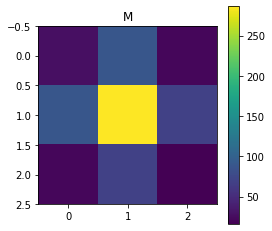

In [19]:
# display learned M
M = B.T @ B
# to preserve memory, uncomment below line
# del B

sg.display_matrix(M, 'M')

# save results
# plt.savefig('results/sg_finalM.png')
# np.savetxt('results/sg_finalB.csv', B, delimiter=',')

Text(0.5, 1.0, 'Time spent to find a valid stepsize in each iteration')

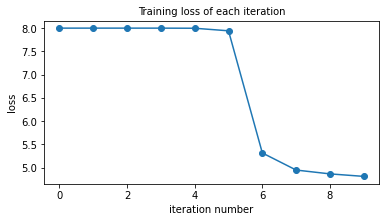

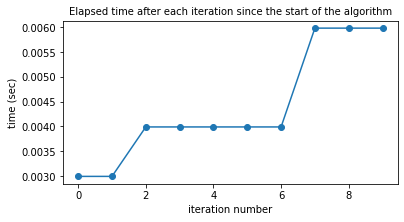

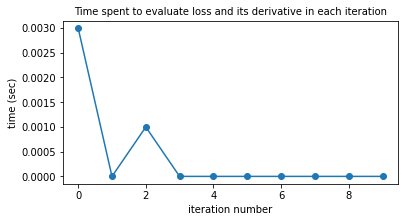

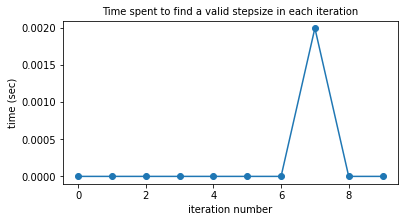

In [17]:
# Some informative figures to compare forced and flexible time complexity
plt.figure(figsize=(6,3))
plt.plot(sg_stats['train_losss'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.title('Training loss of each iteration', fontsize=10)
# plt.savefig('results/sg_trainlosss.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['it_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Elapsed time after each iteration since the start of the algorithm', fontsize=10)
# plt.savefig('results/sg_runtime.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['eval_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Time spent to evaluate loss and its derivative in each iteration', fontsize=10)
# plt.savefig('results/sg_evallosstime.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['stepsizeloop_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Time spent to find a valid stepsize in each iteration', fontsize=10)
# plt.savefig('results/sg_epsilontime.png')

Text(0.5, 1.0, 'Histogram of M entries')

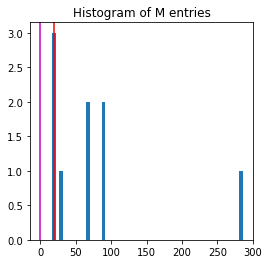

In [18]:
sg.hist_of_entries(M, 50, zeroline=True, peakline=True)
plt.title('Histogram of M entries')